In [221]:
from s04utils.modules.load import timestamps

from bokeh.plotting import figure, show, output_notebook, curdoc
from IPython.core.display import set_matplotlib_formats
import pandas as pd

from sfHMM import sfHMM1


In [222]:
# Set the path to the data

# 'step-like' shape
timestamps_path_01 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/20uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_20uW_77K_circpol_002.h5'

# 'burst-like' shape
timestamps_path_02 = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/05uW/timestamps/tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_012.h5'

In [223]:
# Load timestamps from file

# Timestamps file 01
ts_01 = timestamps.load_from_path(path=timestamps_path_01)

# Timestamps file 02
ts_02 = timestamps.load_from_path(path=timestamps_path_02)

In [224]:
# Set bin time in seconds
bin_time = 0.01

# Create binned timetrace
timetrace01 = ts_01.get_timetrace_data(bin_width=bin_time)

# Get the binned timetrace data for each individual detector
detector0 = timetrace01['detector0'][0]
detector1 = timetrace01['detector1'][0]

# Create a pandas dataframe
df = pd.DataFrame({'detector1': detector1})

# save the dataframe to a csv file without the index
df.to_csv('timetrace.csv', index=False, header=False)


In [225]:
# Set quality for plt plots
set_matplotlib_formats('retina')

# Set output style for bokeh plots
#curdoc().theme = 'dark_minimal'
output_notebook()

/var/folders/2h/6xcys3mx1s7czfj28g_dc70r0000gn/T/ipykernel_8991/3784220441.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


Loading BokehJS ...

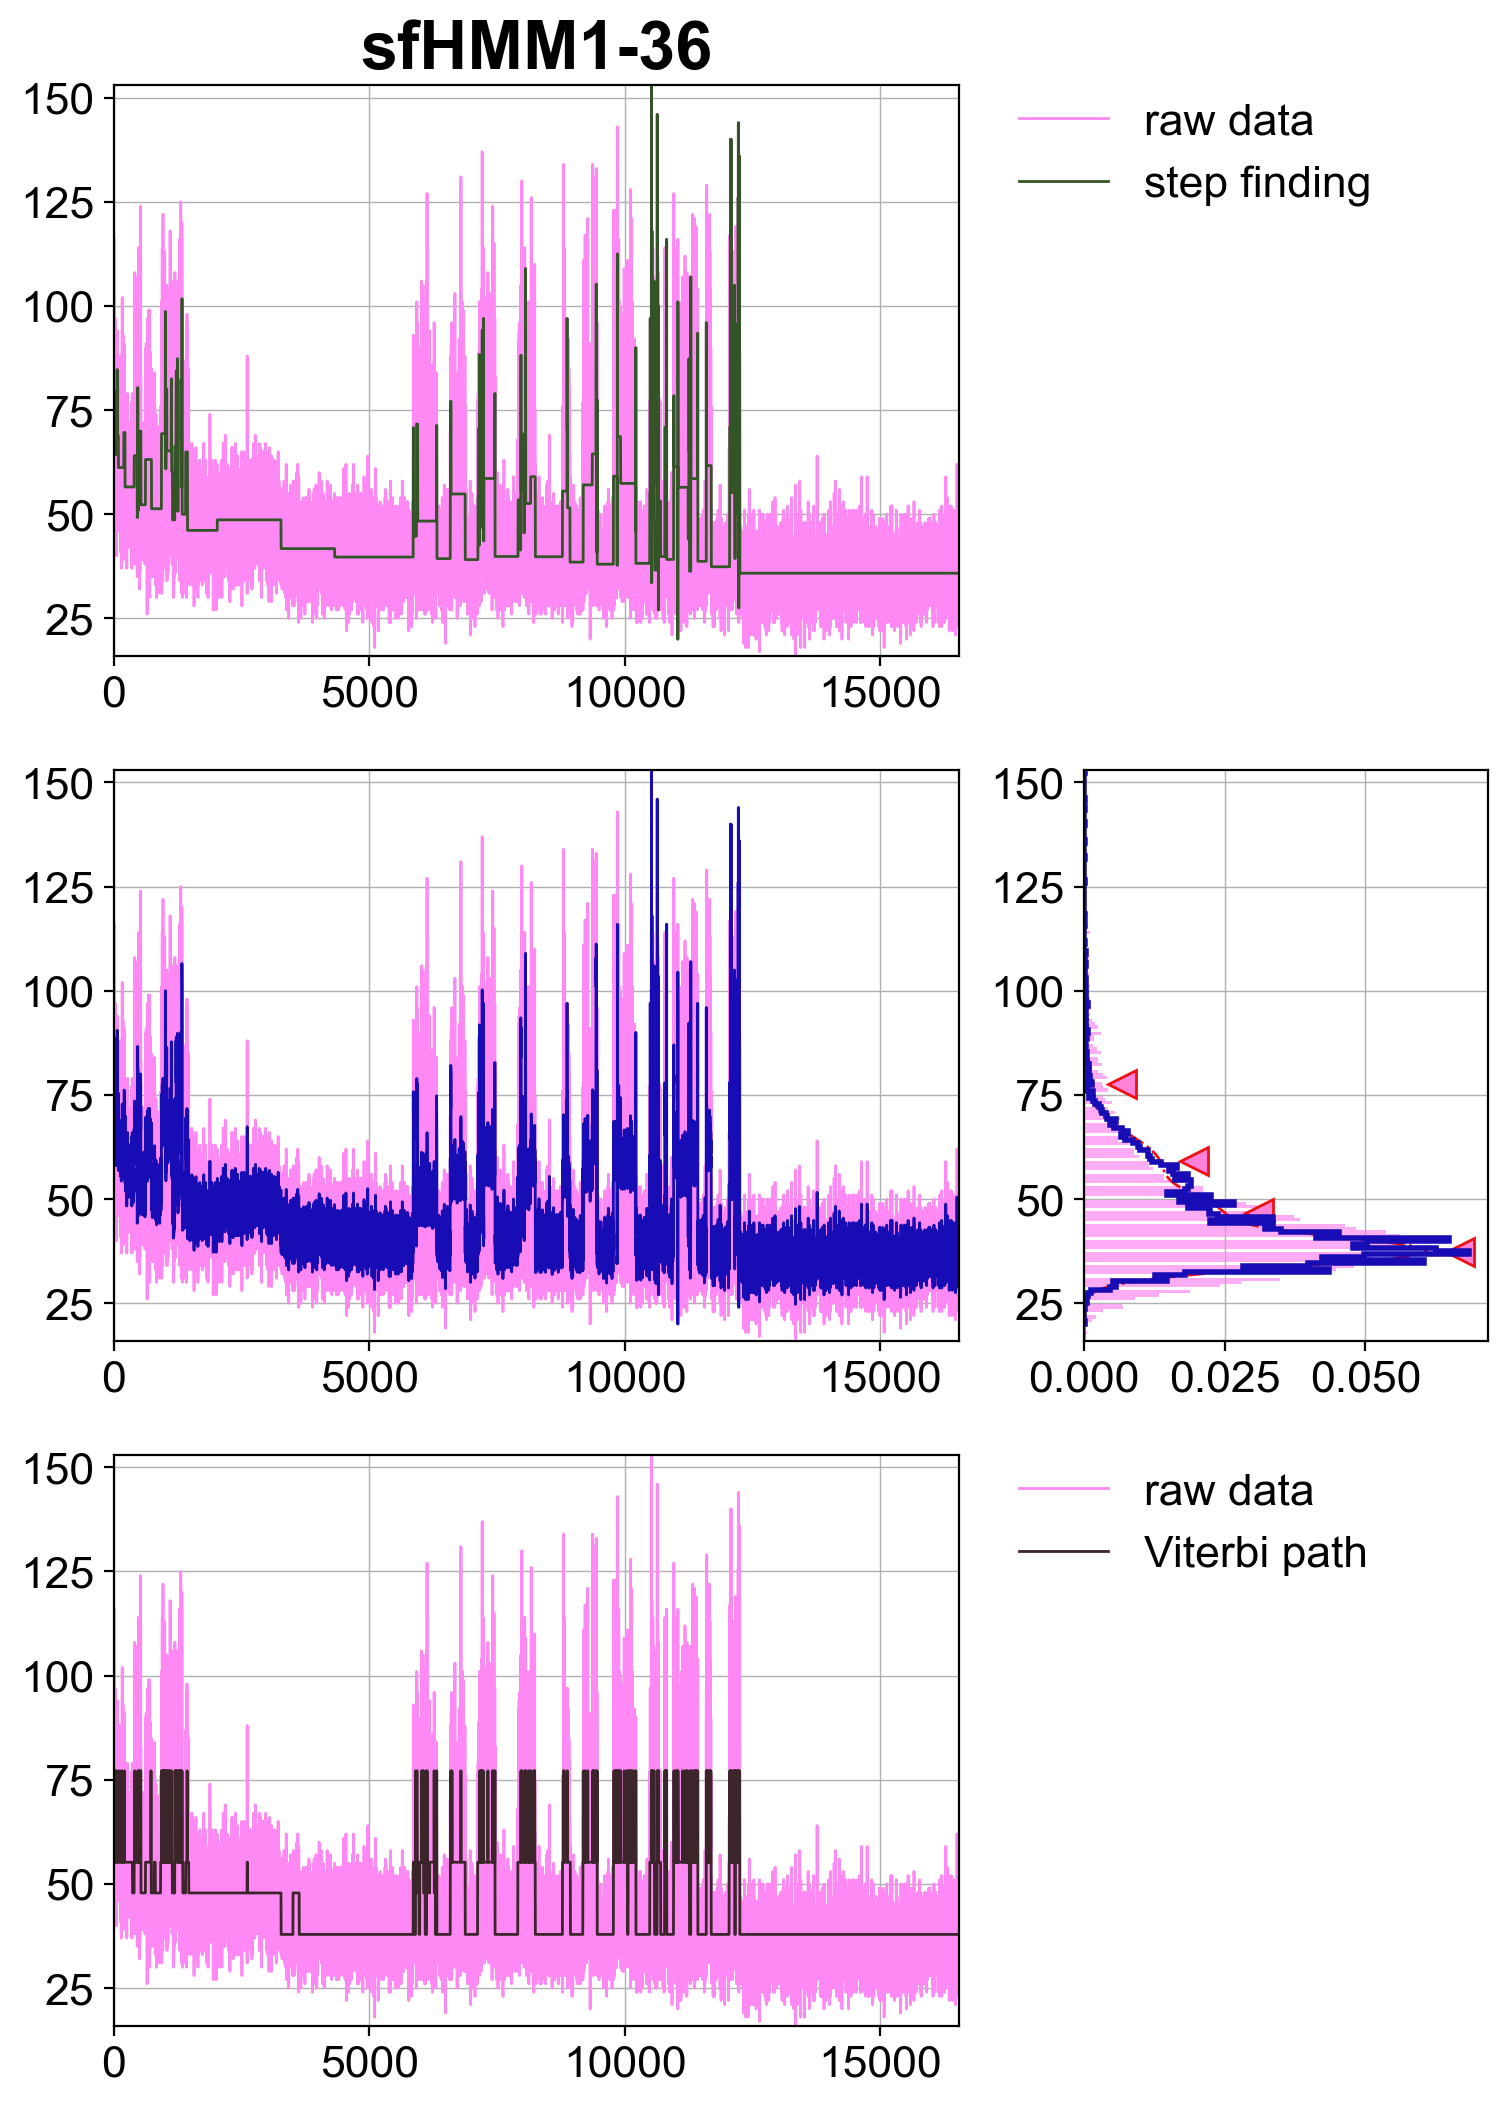

sfHMM1(krange=(1, 6), model='GaussStep', psf=0.007715114361970624,
       sg0=3.4987826263682025)

In [226]:
csv_path = '/Users/kappel/Documents/Programming/python-projects/s04-data-analysis/on-off-times/timetrace.csv'
data = pd.read_csv(csv_path, header=None, index_col=False)

# delete datapoints from 2000 inwards
#data = data.drop(data.index[1500:])

sfHMM1(data, krange=(1, 6)).run_all()

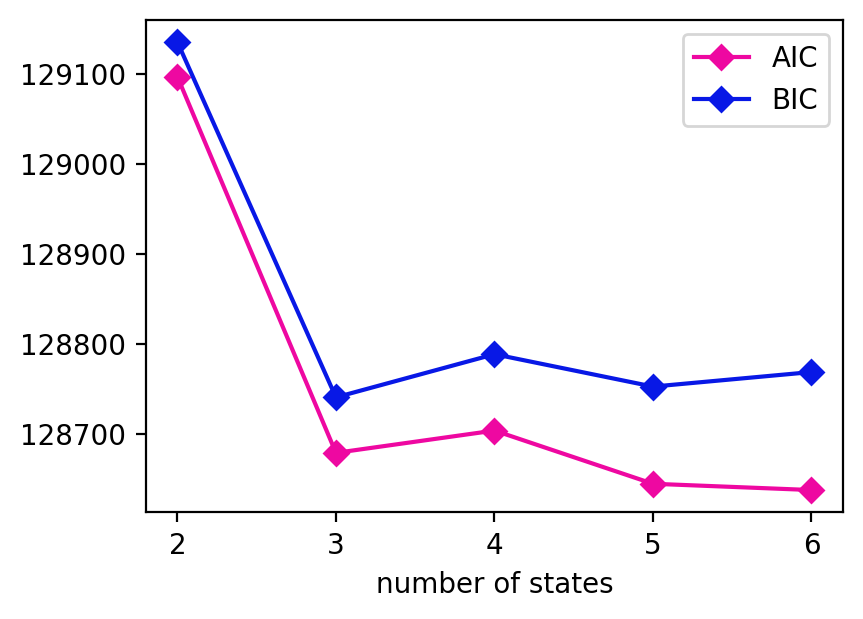

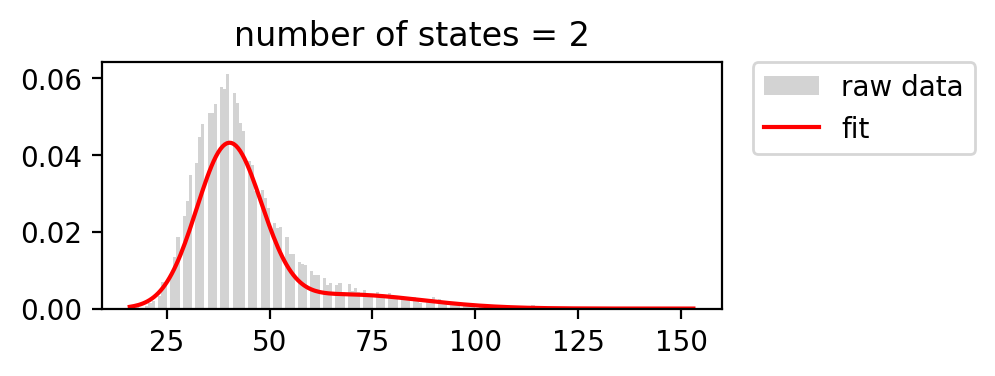

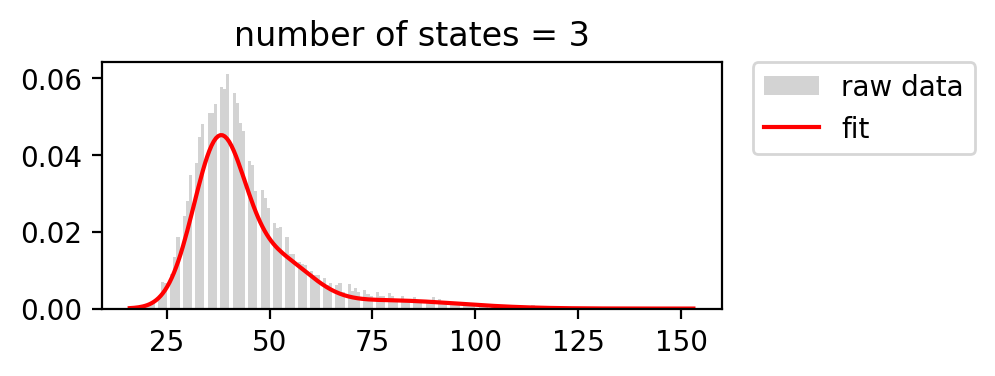

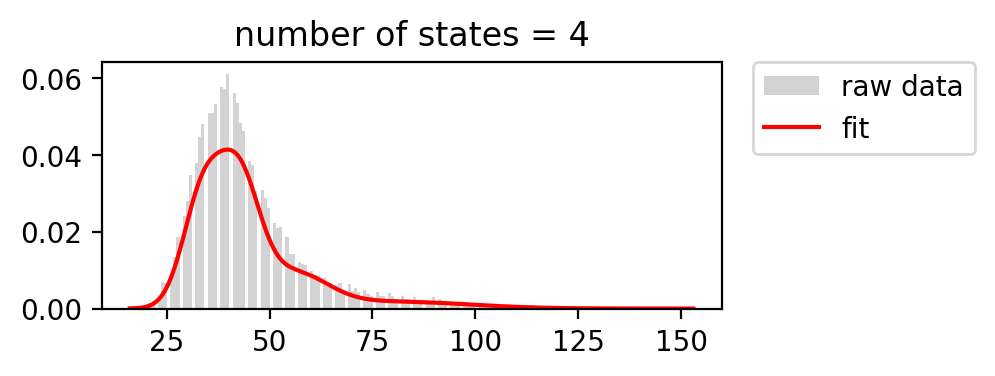

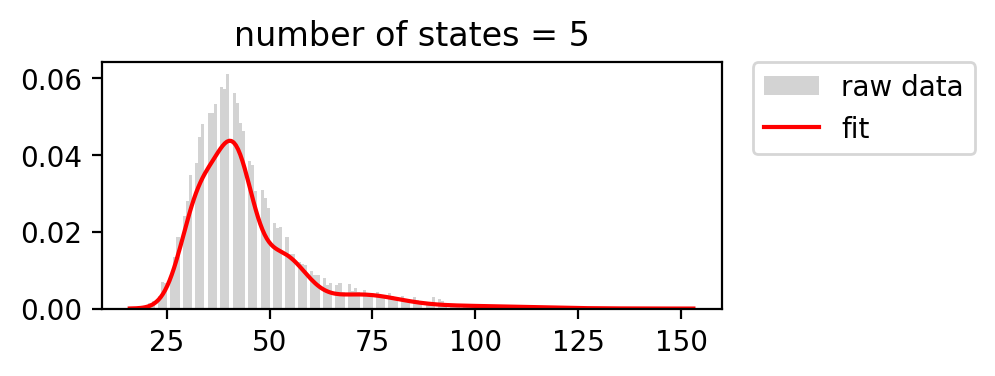

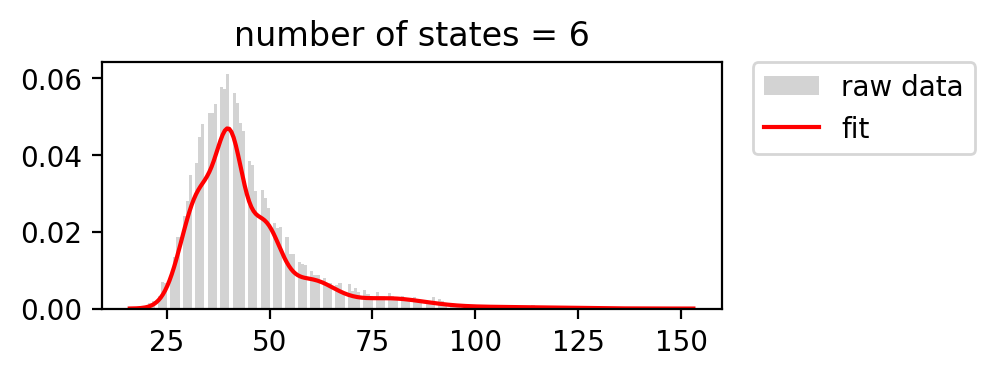

In [227]:
data = pd.read_csv(csv_path, header=None, index_col=False)

from sfHMM.gmm import GMMs
gmms = GMMs(data, krange=(2, 6))
gmms.fit()
gmms.show_aic_bic()
gmms.plot_all()

In [228]:
# get the best model that minimizes BIC
gmm_optimal = gmms.get_optimal(criterion="bic")
print(gmm_optimal)
print("means =\n", gmm_optimal.means_)

GMM1(n_components=3)
means =
 [[37.65565893]
 [51.81299798]
 [77.86886181]]


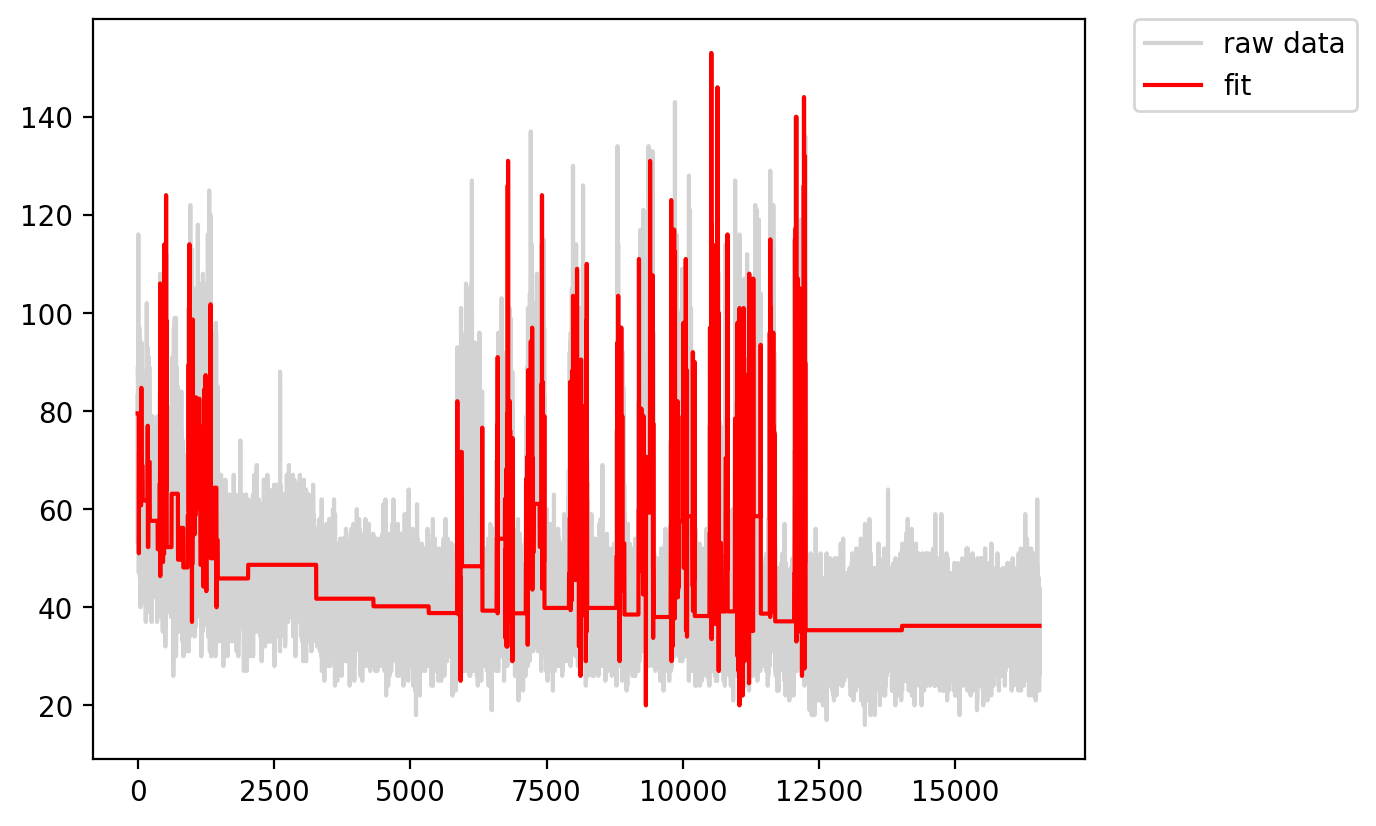

In [229]:
from sfHMM.step import GaussStep, PoissonStep
# simulate a Poissonian trajectory
from matplotlib import pyplot as plt

step_p = PoissonStep(data)
step_p.multi_step_finding() # find steps
step_p.plot() # plot results

